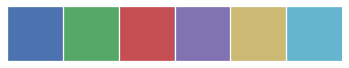

In [1]:
import edward as ed
from edward.models import Uniform
from edward.models import Bernoulli
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

import seaborn as sns
import numpy as np
import six
import matplotlib
matplotlib.interactive(True)

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()

sns.palplot(sns.color_palette())

In [2]:
# initialize a random seed for edward. Can be done ONCE only before using Edward
ed.set_seed(42)

In [3]:
VIDEO_TAG = """<video controls> 
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does noet support the video tag
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        
    return VIDEO_TAG.format(anim._encoded_video)

# Coin

In [4]:
from edward.models import Bernoulli, Beta, Empirical, Uniform

In [5]:
N = 100

In [6]:
def build_fair_dataset(N):
    pheads = tf.constant(0.5)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

In [7]:
def build_unfair_dataset(N):
    pheads = tf.constant(0.05)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

In [8]:
def build_dataset(N):
    pheads = Uniform(low=0.0,high=1.0)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

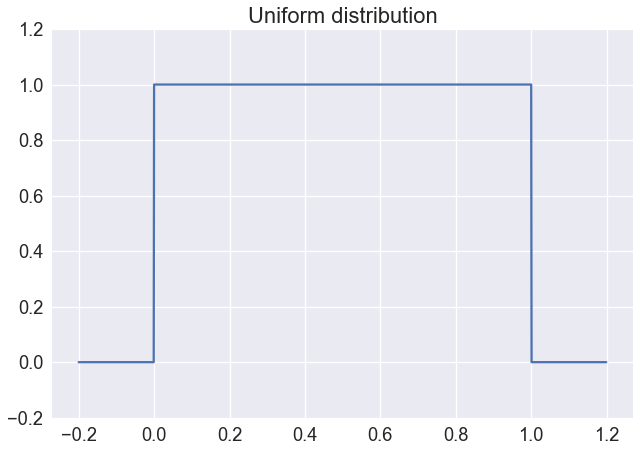

In [9]:
x = tf.range(-0.2, 1.2, 0.001)

plt.plot(*sess.run([x, Uniform(low=0.0,high=1.0).prob(x)]));
plt.ylim((-0.2,1.2))
plt.title('Uniform distribution')

In [10]:
pheads_true,c_train = build_fair_dataset(N)

In [11]:
pheads_true

0.5

In [12]:
c_train

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1])

In [13]:
sum(c_train == 0)

50

In [14]:
sum(c_train == 1)

50

## inference

In [15]:
# declaring priors

pheads_fair = Beta(concentration1=1000.0, concentration0=1000.0) # blue
pheads_unfair = Beta(concentration1=0.1, concentration0=0.1) # green

pheads_unknown = Beta(concentration1 = 1.0, concentration0=1.0)

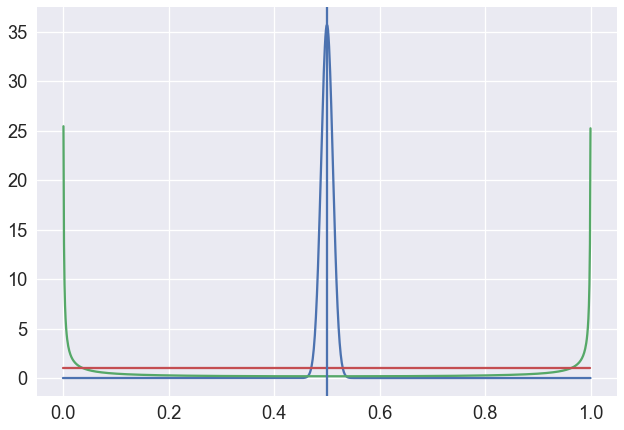

In [16]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x, pheads_fair.prob(x)]));
plt.plot(*sess.run([x, pheads_unfair.prob(x)]));
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));
plt.axvline(x=pheads_true);

In [17]:
# Forward model
pheads = pheads_unknown
c = Bernoulli(probs=pheads, sample_shape=N)

### exact solution

In [19]:
# inference
pheads_cond = ed.complete_conditional(pheads)
pheads_post = ed.copy(pheads_cond, {c: c_train})

In [20]:
sess.run({key:val for key, val in six.iteritems(pheads_post.parameters) if isinstance(val,tf.Tensor)})

{'concentration0': 51.0, 'concentration1': 51.0}

In [21]:
# criticism
mean, stddev = sess.run([pheads_post.mean(),pheads_post.stddev()])
print(" exact posterior mean: " + str(mean))
print("exact posterior std" + str(stddev))

 exact posterior mean: 0.5
exact posterior std0.0492665


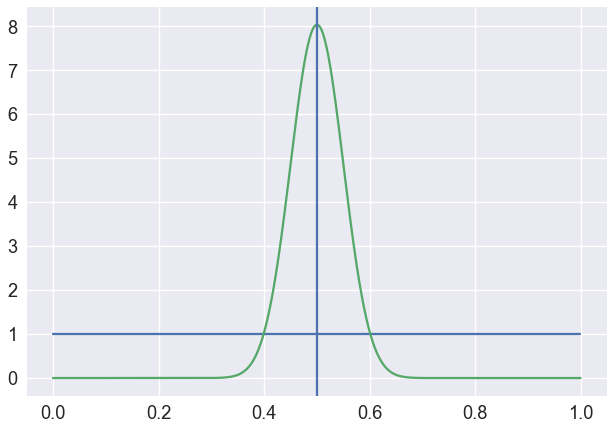

In [22]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_post.prob(x)]));
plt.axvline(x=pheads_true);

## RECURSIVE INFERENCE

finished recursion 1


finished recursion 2


finished recursion 3


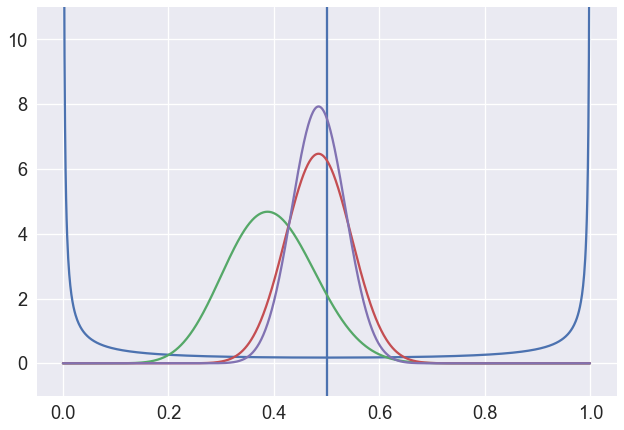

In [23]:
pheads_true,c_train = build_fair_dataset(100)

fig = plt.figure()
ax = plt.axes(xlim=(-0.05,1.05), ylim=(-1.0,11.0))

def go(pheads_prior, sample_shape, c_train, recursion=1):
    # model 
    c = Bernoulli(probs=pheads_prior,
                 sample_shape=sample_shape)
    
    # INFERENCE
    pheads_cond = ed.complete_conditional(pheads_prior)
    pheads_post = ed.copy(pheads_cond,{c:c_train[:sample_shape]})
    
    # CRITICISM
    ax.plot(*sess.run([x,pheads_post.prob(x)]));
    
    print("finished recursion "+str(recursion))
    recursion += 1
    # RECURSION
    if len(c_train[sample_shape:]) >= sample_shape:
        go(pheads_post, sample_shape, c_train[sample_shape:],recursion)
        
pheads_prior = Beta(concentration1=0.1, concentration0=0.1)
ax.plot(*sess.run([x, pheads_prior.prob(x)])); 
plt.axvline(x=pheads_true);
go(pheads_prior,33,c_train)

## approximate inference :MCMC: metroplis hastings:

In [24]:
# BACKWARD MODEL
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

In [25]:
# INFERENCE
proposal_pheads = Beta(concentration1=1.0,
                       concentration0=1.0)
inference = ed.MetropolisHastings(latent_vars = {pheads: q_pheads},
                                 proposal_vars={pheads: proposal_pheads},
                                 data={c:c_train})
inference.run()

    1/10000 [  0%]                                ETA: 9777s | Acceptance Rate: nan

  100/10000 [  1%]                                ETA: 121s | Acceptance Rate: 0.182

  200/10000 [  2%]                                ETA: 71s | Acceptance Rate: 0.151 

  300/10000 [  3%]                                ETA: 53s | Acceptance Rate: 0.167

  400/10000 [  4%] █                              ETA: 44s | Acceptance Rate: 0.165

  500/10000 [  5%] █                              ETA: 38s | Acceptance Rate: 0.170

  600/10000 [  6%] █                              ETA: 34s | Acceptance Rate: 0.169

  700/10000 [  7%] ██                             ETA: 31s | Acceptance Rate: 0.169

  800/10000 [  8%] ██                             ETA: 28s | Acceptance Rate: 0.178

  900/10000 [  9%] ██                             ETA: 27s | Acceptance Rate: 0.179

 1000/10000 [ 10%] ███                            ETA: 25s | Acceptance Rate: 0.171

 1100/10000 [ 11%] ███                            ETA: 24s | Acceptance Rate: 0.170

 1200/10000 [ 12%] ███                            ETA: 23s | Acceptance Rate: 0.171

 1300/10000 [ 13%] ███                            ETA: 22s | Acceptance Rate: 0.170

 1400/10000 [ 14%] ████                           ETA: 21s | Acceptance Rate: 0.165

 1500/10000 [ 15%] ████                           ETA: 20s | Acceptance Rate: 0.165

 1600/10000 [ 16%] ████                           ETA: 20s | Acceptance Rate: 0.166

 1700/10000 [ 17%] █████                          ETA: 19s | Acceptance Rate: 0.164

 1800/10000 [ 18%] █████                          ETA: 18s | Acceptance Rate: 0.167

 1900/10000 [ 19%] █████                          ETA: 18s | Acceptance Rate: 0.166

 2000/10000 [ 20%] ██████                         ETA: 17s | Acceptance Rate: 0.166

 2100/10000 [ 21%] ██████                         ETA: 17s | Acceptance Rate: 0.164

 2200/10000 [ 22%] ██████                         ETA: 17s | Acceptance Rate: 0.165

 2300/10000 [ 23%] ██████                         ETA: 16s | Acceptance Rate: 0.164

 2400/10000 [ 24%] ███████                        ETA: 16s | Acceptance Rate: 0.161

 2500/10000 [ 25%] ███████                        ETA: 15s | Acceptance Rate: 0.159

 2600/10000 [ 26%] ███████                        ETA: 15s | Acceptance Rate: 0.160

 2700/10000 [ 27%] ████████                       ETA: 15s | Acceptance Rate: 0.160

 2800/10000 [ 28%] ████████                       ETA: 14s | Acceptance Rate: 0.159

 2900/10000 [ 28%] ████████                       ETA: 14s | Acceptance Rate: 0.160

 3000/10000 [ 30%] █████████                      ETA: 14s | Acceptance Rate: 0.161

 3100/10000 [ 31%] █████████                      ETA: 13s | Acceptance Rate: 0.161

 3200/10000 [ 32%] █████████                      ETA: 13s | Acceptance Rate: 0.163

 3300/10000 [ 33%] █████████                      ETA: 13s | Acceptance Rate: 0.164

 3400/10000 [ 34%] ██████████                     ETA: 13s | Acceptance Rate: 0.162

 3500/10000 [ 35%] ██████████                     ETA: 12s | Acceptance Rate: 0.164

 3600/10000 [ 36%] ██████████                     ETA: 12s | Acceptance Rate: 0.163

 3700/10000 [ 37%] ███████████                    ETA: 12s | Acceptance Rate: 0.162

 3800/10000 [ 38%] ███████████                    ETA: 12s | Acceptance Rate: 0.162

 3900/10000 [ 39%] ███████████                    ETA: 11s | Acceptance Rate: 0.160

 4000/10000 [ 40%] ████████████                   ETA: 11s | Acceptance Rate: 0.161

 4100/10000 [ 41%] ████████████                   ETA: 11s | Acceptance Rate: 0.161

 4200/10000 [ 42%] ████████████                   ETA: 11s | Acceptance Rate: 0.161

 4300/10000 [ 43%] ████████████                   ETA: 10s | Acceptance Rate: 0.161

 4400/10000 [ 44%] █████████████                  ETA: 10s | Acceptance Rate: 0.160

 4500/10000 [ 45%] █████████████                  ETA: 10s | Acceptance Rate: 0.159

 4600/10000 [ 46%] █████████████                  ETA: 10s | Acceptance Rate: 0.159

 4700/10000 [ 47%] ██████████████                 ETA: 10s | Acceptance Rate: 0.158

 4800/10000 [ 48%] ██████████████                 ETA: 9s | Acceptance Rate: 0.158 

 4900/10000 [ 49%] ██████████████                 ETA: 9s | Acceptance Rate: 0.158

 5000/10000 [ 50%] ███████████████                ETA: 9s | Acceptance Rate: 0.157

 5100/10000 [ 51%] ███████████████                ETA: 9s | Acceptance Rate: 0.157

 5200/10000 [ 52%] ███████████████                ETA: 8s | Acceptance Rate: 0.158

 5300/10000 [ 53%] ███████████████                ETA: 8s | Acceptance Rate: 0.157

 5400/10000 [ 54%] ████████████████               ETA: 8s | Acceptance Rate: 0.158

 5500/10000 [ 55%] ████████████████               ETA: 8s | Acceptance Rate: 0.159

 5600/10000 [ 56%] ████████████████               ETA: 8s | Acceptance Rate: 0.158

 5700/10000 [ 56%] █████████████████              ETA: 7s | Acceptance Rate: 0.158

 5800/10000 [ 57%] █████████████████              ETA: 7s | Acceptance Rate: 0.159

 5900/10000 [ 59%] █████████████████              ETA: 7s | Acceptance Rate: 0.159

 6000/10000 [ 60%] ██████████████████             ETA: 7s | Acceptance Rate: 0.160

 6100/10000 [ 61%] ██████████████████             ETA: 7s | Acceptance Rate: 0.159

 6200/10000 [ 62%] ██████████████████             ETA: 6s | Acceptance Rate: 0.161

 6300/10000 [ 63%] ██████████████████             ETA: 6s | Acceptance Rate: 0.161

 6400/10000 [ 64%] ███████████████████            ETA: 6s | Acceptance Rate: 0.162

 6500/10000 [ 65%] ███████████████████            ETA: 6s | Acceptance Rate: 0.161

 6600/10000 [ 66%] ███████████████████            ETA: 6s | Acceptance Rate: 0.161

 6700/10000 [ 67%] ████████████████████           ETA: 5s | Acceptance Rate: 0.162

 6800/10000 [ 68%] ████████████████████           ETA: 5s | Acceptance Rate: 0.161

 6900/10000 [ 69%] ████████████████████           ETA: 5s | Acceptance Rate: 0.161

 7000/10000 [ 70%] █████████████████████          ETA: 5s | Acceptance Rate: 0.161

 7100/10000 [ 71%] █████████████████████          ETA: 5s | Acceptance Rate: 0.162

 7200/10000 [ 72%] █████████████████████          ETA: 5s | Acceptance Rate: 0.161

 7300/10000 [ 73%] █████████████████████          ETA: 4s | Acceptance Rate: 0.160

 7400/10000 [ 74%] ██████████████████████         ETA: 4s | Acceptance Rate: 0.161

 7500/10000 [ 75%] ██████████████████████         ETA: 4s | Acceptance Rate: 0.161

 7600/10000 [ 76%] ██████████████████████         ETA: 4s | Acceptance Rate: 0.161

 7700/10000 [ 77%] ███████████████████████        ETA: 4s | Acceptance Rate: 0.162

 7800/10000 [ 78%] ███████████████████████        ETA: 3s | Acceptance Rate: 0.162

 7900/10000 [ 79%] ███████████████████████        ETA: 3s | Acceptance Rate: 0.162

 8000/10000 [ 80%] ████████████████████████       ETA: 3s | Acceptance Rate: 0.162

 8100/10000 [ 81%] ████████████████████████       ETA: 3s | Acceptance Rate: 0.162

 8200/10000 [ 82%] ████████████████████████       ETA: 3s | Acceptance Rate: 0.161

 8300/10000 [ 83%] ████████████████████████       ETA: 3s | Acceptance Rate: 0.162

 8400/10000 [ 84%] █████████████████████████      ETA: 2s | Acceptance Rate: 0.163

 8500/10000 [ 85%] █████████████████████████      ETA: 2s | Acceptance Rate: 0.162

 8600/10000 [ 86%] █████████████████████████      ETA: 2s | Acceptance Rate: 0.162

 8700/10000 [ 87%] ██████████████████████████     ETA: 2s | Acceptance Rate: 0.163

 8800/10000 [ 88%] ██████████████████████████     ETA: 2s | Acceptance Rate: 0.163

 8900/10000 [ 89%] ██████████████████████████     ETA: 1s | Acceptance Rate: 0.163

 9000/10000 [ 90%] ███████████████████████████    ETA: 1s | Acceptance Rate: 0.163

 9100/10000 [ 91%] ███████████████████████████    ETA: 1s | Acceptance Rate: 0.162

 9200/10000 [ 92%] ███████████████████████████    ETA: 1s | Acceptance Rate: 0.162

 9300/10000 [ 93%] ███████████████████████████    ETA: 1s | Acceptance Rate: 0.162

 9400/10000 [ 94%] ████████████████████████████   ETA: 1s | Acceptance Rate: 0.162

 9500/10000 [ 95%] ████████████████████████████   ETA: 0s | Acceptance Rate: 0.162

 9600/10000 [ 96%] ████████████████████████████   ETA: 0s | Acceptance Rate: 0.162

 9700/10000 [ 97%] █████████████████████████████  ETA: 0s | Acceptance Rate: 0.162

 9800/10000 [ 98%] █████████████████████████████  ETA: 0s | Acceptance Rate: 0.162

 9900/10000 [ 99%] █████████████████████████████  ETA: 0s | Acceptance Rate: 0.162

10000/10000 [100%] ██████████████████████████████ Elapsed: 17s | Acceptance Rate: 0.161

In [26]:
# criticism
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print("inferred posterior mean:")
print(mean)
print("inferred posterior std:")
print(stddev)

inferred posterior mean:
0.488378
inferred posterior std:
0.049427


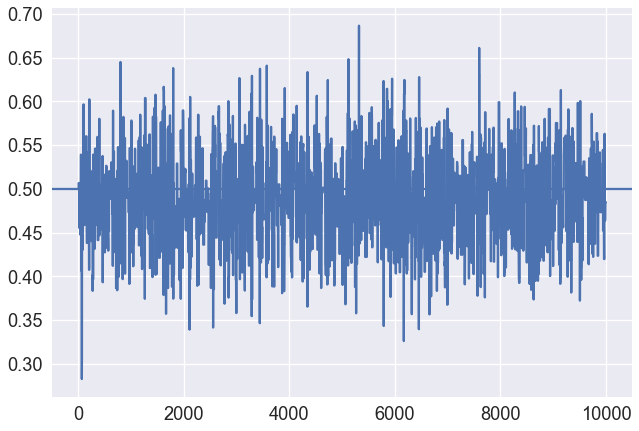

In [27]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true)

In [28]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) *tf.reduce_mean(tf.square(x-mean))
    ret = tf.map_fn(lambda k:tf.cond(tf.equal(k,0),
                                     lambda:var, 
                                     lambda:tf.reduce_sum((x[:-k] - mean) * (x[k:]-mean))),
                                     tf.range(0,tf.size(x)),
                                     dtype=tf.float32)
    return ret / var

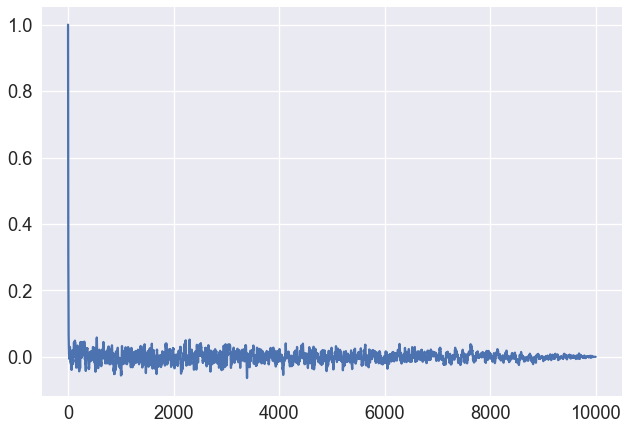

In [29]:
plt.plot(lags(q_pheads.params).eval());

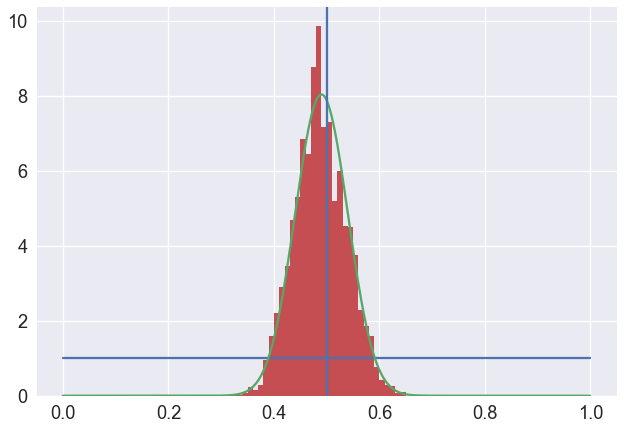

In [30]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_cond.prob(x)],
                  {c:c_train}));
plt.hist(q_pheads.params.eval(),
        bins=100,range=(0.0,1.0),
        normed = True);
plt.axvline(x=pheads_true);

## MCMC: Gibbs

In [31]:
# BACKWARD MODEL
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

In [32]:
# INFERENCE 
inference = ed.Gibbs(latent_vars={pheads: q_pheads},
                    data={c: c_train})
inference.run()

    1/10000 [  0%]                                ETA: 8471s | Acceptance Rate: inf

  100/10000 [  1%]                                ETA: 139s | Acceptance Rate: 1.010

  200/10000 [  2%]                                ETA: 96s | Acceptance Rate: 1.005 

  300/10000 [  3%]                                ETA: 80s | Acceptance Rate: 1.003

  400/10000 [  4%] █                              ETA: 74s | Acceptance Rate: 1.003

  500/10000 [  5%] █                              ETA: 71s | Acceptance Rate: 1.002

  600/10000 [  6%] █                              ETA: 67s | Acceptance Rate: 1.002

  700/10000 [  7%] ██                             ETA: 64s | Acceptance Rate: 1.001

  800/10000 [  8%] ██                             ETA: 62s | Acceptance Rate: 1.001

  900/10000 [  9%] ██                             ETA: 60s | Acceptance Rate: 1.001

 1000/10000 [ 10%] ███                            ETA: 56s | Acceptance Rate: 1.001

 1100/10000 [ 11%] ███                            ETA: 54s | Acceptance Rate: 1.001

 1200/10000 [ 12%] ███                            ETA: 51s | Acceptance Rate: 1.001

 1300/10000 [ 13%] ███                            ETA: 49s | Acceptance Rate: 1.001

 1400/10000 [ 14%] ████                           ETA: 47s | Acceptance Rate: 1.001

 1500/10000 [ 15%] ████                           ETA: 46s | Acceptance Rate: 1.001

 1600/10000 [ 16%] ████                           ETA: 45s | Acceptance Rate: 1.001

 1700/10000 [ 17%] █████                          ETA: 43s | Acceptance Rate: 1.001

 1800/10000 [ 18%] █████                          ETA: 42s | Acceptance Rate: 1.001

 1900/10000 [ 19%] █████                          ETA: 41s | Acceptance Rate: 1.001

 2000/10000 [ 20%] ██████                         ETA: 40s | Acceptance Rate: 1.001

 2100/10000 [ 21%] ██████                         ETA: 39s | Acceptance Rate: 1.000

 2200/10000 [ 22%] ██████                         ETA: 38s | Acceptance Rate: 1.000

 2300/10000 [ 23%] ██████                         ETA: 37s | Acceptance Rate: 1.000

 2400/10000 [ 24%] ███████                        ETA: 36s | Acceptance Rate: 1.000

 2500/10000 [ 25%] ███████                        ETA: 35s | Acceptance Rate: 1.000

 2600/10000 [ 26%] ███████                        ETA: 34s | Acceptance Rate: 1.000

 2700/10000 [ 27%] ████████                       ETA: 33s | Acceptance Rate: 1.000

 2800/10000 [ 28%] ████████                       ETA: 32s | Acceptance Rate: 1.000

 2900/10000 [ 28%] ████████                       ETA: 32s | Acceptance Rate: 1.000

 3000/10000 [ 30%] █████████                      ETA: 31s | Acceptance Rate: 1.000

 3100/10000 [ 31%] █████████                      ETA: 30s | Acceptance Rate: 1.000

 3200/10000 [ 32%] █████████                      ETA: 30s | Acceptance Rate: 1.000

 3300/10000 [ 33%] █████████                      ETA: 29s | Acceptance Rate: 1.000

 3400/10000 [ 34%] ██████████                     ETA: 28s | Acceptance Rate: 1.000

 3500/10000 [ 35%] ██████████                     ETA: 28s | Acceptance Rate: 1.000

 3600/10000 [ 36%] ██████████                     ETA: 27s | Acceptance Rate: 1.000

 3700/10000 [ 37%] ███████████                    ETA: 27s | Acceptance Rate: 1.000

 3800/10000 [ 38%] ███████████                    ETA: 26s | Acceptance Rate: 1.000

 3900/10000 [ 39%] ███████████                    ETA: 25s | Acceptance Rate: 1.000

 4000/10000 [ 40%] ████████████                   ETA: 25s | Acceptance Rate: 1.000

 4100/10000 [ 41%] ████████████                   ETA: 24s | Acceptance Rate: 1.000

 4200/10000 [ 42%] ████████████                   ETA: 24s | Acceptance Rate: 1.000

 4300/10000 [ 43%] ████████████                   ETA: 24s | Acceptance Rate: 1.000

 4400/10000 [ 44%] █████████████                  ETA: 23s | Acceptance Rate: 1.000

 4500/10000 [ 45%] █████████████                  ETA: 23s | Acceptance Rate: 1.000

 4600/10000 [ 46%] █████████████                  ETA: 23s | Acceptance Rate: 1.000

 4700/10000 [ 47%] ██████████████                 ETA: 22s | Acceptance Rate: 1.000

 4800/10000 [ 48%] ██████████████                 ETA: 22s | Acceptance Rate: 1.000

 4900/10000 [ 49%] ██████████████                 ETA: 21s | Acceptance Rate: 1.000

 5000/10000 [ 50%] ███████████████                ETA: 21s | Acceptance Rate: 1.000

 5100/10000 [ 51%] ███████████████                ETA: 20s | Acceptance Rate: 1.000

 5200/10000 [ 52%] ███████████████                ETA: 20s | Acceptance Rate: 1.000

 5300/10000 [ 53%] ███████████████                ETA: 19s | Acceptance Rate: 1.000

 5400/10000 [ 54%] ████████████████               ETA: 19s | Acceptance Rate: 1.000

 5500/10000 [ 55%] ████████████████               ETA: 18s | Acceptance Rate: 1.000

 5600/10000 [ 56%] ████████████████               ETA: 18s | Acceptance Rate: 1.000

 5700/10000 [ 56%] █████████████████              ETA: 17s | Acceptance Rate: 1.000

 5800/10000 [ 57%] █████████████████              ETA: 17s | Acceptance Rate: 1.000

 5900/10000 [ 59%] █████████████████              ETA: 16s | Acceptance Rate: 1.000

 6000/10000 [ 60%] ██████████████████             ETA: 16s | Acceptance Rate: 1.000

 6100/10000 [ 61%] ██████████████████             ETA: 16s | Acceptance Rate: 1.000

 6200/10000 [ 62%] ██████████████████             ETA: 15s | Acceptance Rate: 1.000

 6300/10000 [ 63%] ██████████████████             ETA: 15s | Acceptance Rate: 1.000

 6400/10000 [ 64%] ███████████████████            ETA: 14s | Acceptance Rate: 1.000

 6500/10000 [ 65%] ███████████████████            ETA: 14s | Acceptance Rate: 1.000

 6600/10000 [ 66%] ███████████████████            ETA: 13s | Acceptance Rate: 1.000

 6700/10000 [ 67%] ████████████████████           ETA: 13s | Acceptance Rate: 1.000

 6800/10000 [ 68%] ████████████████████           ETA: 12s | Acceptance Rate: 1.000

 6900/10000 [ 69%] ████████████████████           ETA: 12s | Acceptance Rate: 1.000

 7000/10000 [ 70%] █████████████████████          ETA: 12s | Acceptance Rate: 1.000

 7100/10000 [ 71%] █████████████████████          ETA: 11s | Acceptance Rate: 1.000

 7200/10000 [ 72%] █████████████████████          ETA: 11s | Acceptance Rate: 1.000

 7300/10000 [ 73%] █████████████████████          ETA: 10s | Acceptance Rate: 1.000

 7400/10000 [ 74%] ██████████████████████         ETA: 10s | Acceptance Rate: 1.000

 7500/10000 [ 75%] ██████████████████████         ETA: 10s | Acceptance Rate: 1.000

 7600/10000 [ 76%] ██████████████████████         ETA: 9s | Acceptance Rate: 1.000 

 7700/10000 [ 77%] ███████████████████████        ETA: 9s | Acceptance Rate: 1.000

 7800/10000 [ 78%] ███████████████████████        ETA: 8s | Acceptance Rate: 1.000

 7900/10000 [ 79%] ███████████████████████        ETA: 8s | Acceptance Rate: 1.000

 8000/10000 [ 80%] ████████████████████████       ETA: 7s | Acceptance Rate: 1.000

 8100/10000 [ 81%] ████████████████████████       ETA: 7s | Acceptance Rate: 1.000

 8200/10000 [ 82%] ████████████████████████       ETA: 7s | Acceptance Rate: 1.000

 8300/10000 [ 83%] ████████████████████████       ETA: 6s | Acceptance Rate: 1.000

 8400/10000 [ 84%] █████████████████████████      ETA: 6s | Acceptance Rate: 1.000

 8500/10000 [ 85%] █████████████████████████      ETA: 5s | Acceptance Rate: 1.000

 8600/10000 [ 86%] █████████████████████████      ETA: 5s | Acceptance Rate: 1.000

 8700/10000 [ 87%] ██████████████████████████     ETA: 5s | Acceptance Rate: 1.000

 8800/10000 [ 88%] ██████████████████████████     ETA: 4s | Acceptance Rate: 1.000

 8900/10000 [ 89%] ██████████████████████████     ETA: 4s | Acceptance Rate: 1.000

 9000/10000 [ 90%] ███████████████████████████    ETA: 3s | Acceptance Rate: 1.000

 9100/10000 [ 91%] ███████████████████████████    ETA: 3s | Acceptance Rate: 1.000

 9200/10000 [ 92%] ███████████████████████████    ETA: 3s | Acceptance Rate: 1.000

 9300/10000 [ 93%] ███████████████████████████    ETA: 2s | Acceptance Rate: 1.000

 9400/10000 [ 94%] ████████████████████████████   ETA: 2s | Acceptance Rate: 1.000

 9500/10000 [ 95%] ████████████████████████████   ETA: 1s | Acceptance Rate: 1.000

 9600/10000 [ 96%] ████████████████████████████   ETA: 1s | Acceptance Rate: 1.000

 9700/10000 [ 97%] █████████████████████████████  ETA: 1s | Acceptance Rate: 1.000

 9800/10000 [ 98%] █████████████████████████████  ETA: 0s | Acceptance Rate: 1.000

 9900/10000 [ 99%] █████████████████████████████  ETA: 0s | Acceptance Rate: 1.000

10000/10000 [100%] ██████████████████████████████ Elapsed: 39s | Acceptance Rate: 1.000

In [41]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print('Inferred posterior mean:')
print(mean)
print('Inferred posterior std:')
print(stddev)

Inferred posterior mean:
0.490163
Inferred posterior std:
0.0493696


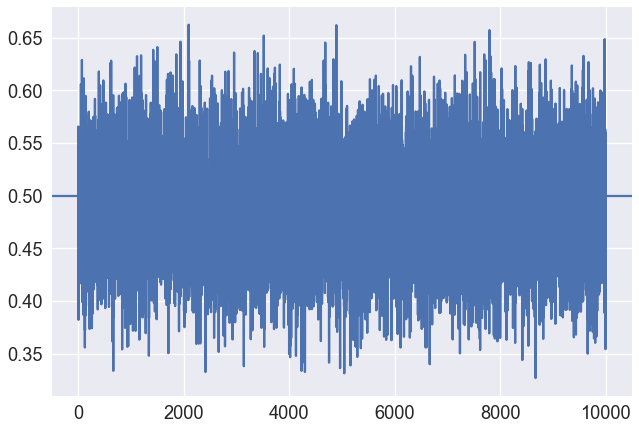

In [34]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true)

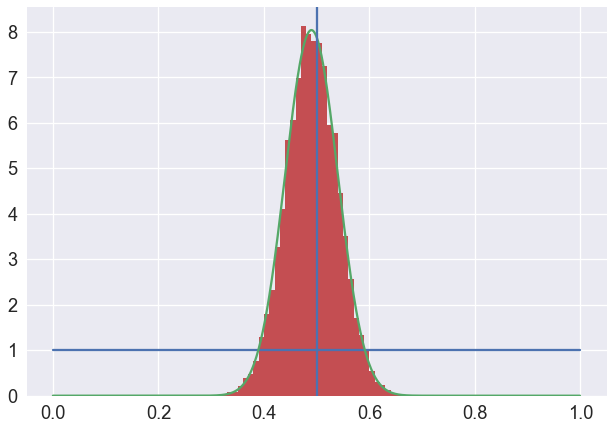

In [35]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_cond.prob(x)],
                  {c:c_train}));
plt.hist(q_pheads.params.eval(),
        bins=100,range=(0.0,1.0),
        normed = True);
plt.axvline(x=pheads_true);

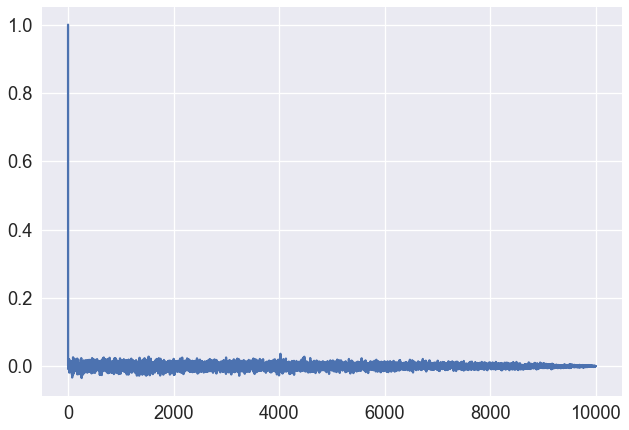

In [36]:
plt.plot(lags(q_pheads.params).eval());

## MCMC: Hamiltonian monte carlo

Metropolis hasting and Gibbs will fail in high_dimensional paramter space while HMC will not. 

HMC unitlises the geometry of the important regions of the posterior (where the probability mass is concentrated) to guide the jump proposal.

For Gibbs you need to be able to derive the complete conditional algebraically. Most of the times this is not the case, so Gibbs cannot be used. Hamiltonian monte carlo does not have this restriction. However, it only works for continuous variables. This is because it works with derivatives (i.e. we need smooth functions).


In [37]:
# BACKWARD MODEL
T = 10000 # number of empirical samples
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [41]:
# INFERENCE
inference = ed.HMC(latent_vars={pheads: q_pheads},
                  data = {c: c_train})
inference.run(step_size=1.0 / N, n_steps=20)

    1/10000 [  0%]                                ETA: 104024s | Acceptance Rate: nan

  100/10000 [  1%]                                ETA: 1180s | Acceptance Rate: 0.990

  200/10000 [  2%]                                ETA: 655s | Acceptance Rate: 0.980 

  300/10000 [  3%]                                ETA: 479s | Acceptance Rate: 0.983

  400/10000 [  4%] █                              ETA: 389s | Acceptance Rate: 0.987

  500/10000 [  5%] █                              ETA: 336s | Acceptance Rate: 0.990

  600/10000 [  6%] █                              ETA: 301s | Acceptance Rate: 0.992

  700/10000 [  7%] ██                             ETA: 274s | Acceptance Rate: 0.993

  800/10000 [  8%] ██                             ETA: 255s | Acceptance Rate: 0.994

  900/10000 [  9%] ██                             ETA: 238s | Acceptance Rate: 0.993

 1000/10000 [ 10%] ███                            ETA: 226s | Acceptance Rate: 0.994

 1100/10000 [ 11%] ███                            ETA: 215s | Acceptance Rate: 0.995

 1200/10000 [ 12%] ███                            ETA: 206s | Acceptance Rate: 0.994

 1300/10000 [ 13%] ███                            ETA: 198s | Acceptance Rate: 0.995

 1400/10000 [ 14%] ████                           ETA: 192s | Acceptance Rate: 0.995

 1500/10000 [ 15%] ████                           ETA: 186s | Acceptance Rate: 0.995

 1600/10000 [ 16%] ████                           ETA: 180s | Acceptance Rate: 0.996

 1700/10000 [ 17%] █████                          ETA: 175s | Acceptance Rate: 0.996

 1800/10000 [ 18%] █████                          ETA: 170s | Acceptance Rate: 0.996

 1900/10000 [ 19%] █████                          ETA: 166s | Acceptance Rate: 0.996

 2000/10000 [ 20%] ██████                         ETA: 162s | Acceptance Rate: 0.996

 2100/10000 [ 21%] ██████                         ETA: 158s | Acceptance Rate: 0.996

 2200/10000 [ 22%] ██████                         ETA: 154s | Acceptance Rate: 0.996

 2300/10000 [ 23%] ██████                         ETA: 150s | Acceptance Rate: 0.996

 2400/10000 [ 24%] ███████                        ETA: 147s | Acceptance Rate: 0.996

 2500/10000 [ 25%] ███████                        ETA: 142s | Acceptance Rate: 0.996

 2600/10000 [ 26%] ███████                        ETA: 137s | Acceptance Rate: 0.997

 2700/10000 [ 27%] ████████                       ETA: 132s | Acceptance Rate: 0.997

 2800/10000 [ 28%] ████████                       ETA: 128s | Acceptance Rate: 0.997

 2900/10000 [ 28%] ████████                       ETA: 124s | Acceptance Rate: 0.997

 3000/10000 [ 30%] █████████                      ETA: 120s | Acceptance Rate: 0.996

 3100/10000 [ 31%] █████████                      ETA: 116s | Acceptance Rate: 0.996

 3200/10000 [ 32%] █████████                      ETA: 112s | Acceptance Rate: 0.996

 3300/10000 [ 33%] █████████                      ETA: 109s | Acceptance Rate: 0.996

 3400/10000 [ 34%] ██████████                     ETA: 106s | Acceptance Rate: 0.996

 3500/10000 [ 35%] ██████████                     ETA: 104s | Acceptance Rate: 0.995

 3600/10000 [ 36%] ██████████                     ETA: 102s | Acceptance Rate: 0.996

 3700/10000 [ 37%] ███████████                    ETA: 100s | Acceptance Rate: 0.995

 3800/10000 [ 38%] ███████████                    ETA: 99s | Acceptance Rate: 0.996 

 3900/10000 [ 39%] ███████████                    ETA: 97s | Acceptance Rate: 0.996

 4000/10000 [ 40%] ████████████                   ETA: 95s | Acceptance Rate: 0.995

 4100/10000 [ 41%] ████████████                   ETA: 93s | Acceptance Rate: 0.996

 4200/10000 [ 42%] ████████████                   ETA: 91s | Acceptance Rate: 0.996

 4300/10000 [ 43%] ████████████                   ETA: 89s | Acceptance Rate: 0.996

 4400/10000 [ 44%] █████████████                  ETA: 88s | Acceptance Rate: 0.996

 4500/10000 [ 45%] █████████████                  ETA: 86s | Acceptance Rate: 0.996

 4600/10000 [ 46%] █████████████                  ETA: 84s | Acceptance Rate: 0.996

 4700/10000 [ 47%] ██████████████                 ETA: 83s | Acceptance Rate: 0.996

 4800/10000 [ 48%] ██████████████                 ETA: 81s | Acceptance Rate: 0.996

 4900/10000 [ 49%] ██████████████                 ETA: 79s | Acceptance Rate: 0.996

 5000/10000 [ 50%] ███████████████                ETA: 78s | Acceptance Rate: 0.996

 5100/10000 [ 51%] ███████████████                ETA: 76s | Acceptance Rate: 0.996

 5200/10000 [ 52%] ███████████████                ETA: 74s | Acceptance Rate: 0.996

 5300/10000 [ 53%] ███████████████                ETA: 73s | Acceptance Rate: 0.996

 5400/10000 [ 54%] ████████████████               ETA: 71s | Acceptance Rate: 0.996

 5500/10000 [ 55%] ████████████████               ETA: 70s | Acceptance Rate: 0.996

 5600/10000 [ 56%] ████████████████               ETA: 68s | Acceptance Rate: 0.996

 5700/10000 [ 56%] █████████████████              ETA: 67s | Acceptance Rate: 0.996

 5800/10000 [ 57%] █████████████████              ETA: 65s | Acceptance Rate: 0.996

 5900/10000 [ 59%] █████████████████              ETA: 63s | Acceptance Rate: 0.996

 6000/10000 [ 60%] ██████████████████             ETA: 62s | Acceptance Rate: 0.996

 6100/10000 [ 61%] ██████████████████             ETA: 60s | Acceptance Rate: 0.996

 6200/10000 [ 62%] ██████████████████             ETA: 58s | Acceptance Rate: 0.996

 6300/10000 [ 63%] ██████████████████             ETA: 57s | Acceptance Rate: 0.996

 6400/10000 [ 64%] ███████████████████            ETA: 55s | Acceptance Rate: 0.996

 6500/10000 [ 65%] ███████████████████            ETA: 54s | Acceptance Rate: 0.996

 6600/10000 [ 66%] ███████████████████            ETA: 52s | Acceptance Rate: 0.996

 6700/10000 [ 67%] ████████████████████           ETA: 50s | Acceptance Rate: 0.996

 6800/10000 [ 68%] ████████████████████           ETA: 49s | Acceptance Rate: 0.996

 6900/10000 [ 69%] ████████████████████           ETA: 47s | Acceptance Rate: 0.996

 7000/10000 [ 70%] █████████████████████          ETA: 45s | Acceptance Rate: 0.996

 7100/10000 [ 71%] █████████████████████          ETA: 44s | Acceptance Rate: 0.996

 7200/10000 [ 72%] █████████████████████          ETA: 42s | Acceptance Rate: 0.997

 7300/10000 [ 73%] █████████████████████          ETA: 41s | Acceptance Rate: 0.997

 7400/10000 [ 74%] ██████████████████████         ETA: 39s | Acceptance Rate: 0.997

 7500/10000 [ 75%] ██████████████████████         ETA: 38s | Acceptance Rate: 0.997

 7600/10000 [ 76%] ██████████████████████         ETA: 36s | Acceptance Rate: 0.997

 7700/10000 [ 77%] ███████████████████████        ETA: 35s | Acceptance Rate: 0.997

 7800/10000 [ 78%] ███████████████████████        ETA: 33s | Acceptance Rate: 0.997

 7900/10000 [ 79%] ███████████████████████        ETA: 32s | Acceptance Rate: 0.997

 8000/10000 [ 80%] ████████████████████████       ETA: 30s | Acceptance Rate: 0.997

 8100/10000 [ 81%] ████████████████████████       ETA: 29s | Acceptance Rate: 0.997

 8200/10000 [ 82%] ████████████████████████       ETA: 27s | Acceptance Rate: 0.997

 8300/10000 [ 83%] ████████████████████████       ETA: 26s | Acceptance Rate: 0.997

 8400/10000 [ 84%] █████████████████████████      ETA: 24s | Acceptance Rate: 0.997

 8500/10000 [ 85%] █████████████████████████      ETA: 22s | Acceptance Rate: 0.997

 8600/10000 [ 86%] █████████████████████████      ETA: 21s | Acceptance Rate: 0.997

 8700/10000 [ 87%] ██████████████████████████     ETA: 19s | Acceptance Rate: 0.997

 8800/10000 [ 88%] ██████████████████████████     ETA: 18s | Acceptance Rate: 0.997

 8900/10000 [ 89%] ██████████████████████████     ETA: 16s | Acceptance Rate: 0.997

 9000/10000 [ 90%] ███████████████████████████    ETA: 15s | Acceptance Rate: 0.997

 9100/10000 [ 91%] ███████████████████████████    ETA: 13s | Acceptance Rate: 0.997

 9200/10000 [ 92%] ███████████████████████████    ETA: 12s | Acceptance Rate: 0.997

 9300/10000 [ 93%] ███████████████████████████    ETA: 10s | Acceptance Rate: 0.997

 9400/10000 [ 94%] ████████████████████████████   ETA: 9s | Acceptance Rate: 0.997 

 9500/10000 [ 95%] ████████████████████████████   ETA: 7s | Acceptance Rate: 0.997

 9600/10000 [ 96%] ████████████████████████████   ETA: 6s | Acceptance Rate: 0.997

 9700/10000 [ 97%] █████████████████████████████  ETA: 4s | Acceptance Rate: 0.997

 9800/10000 [ 98%] █████████████████████████████  ETA: 3s | Acceptance Rate: 0.997

 9900/10000 [ 99%] █████████████████████████████  ETA: 1s | Acceptance Rate: 0.997

10000/10000 [100%] ██████████████████████████████ Elapsed: 153s | Acceptance Rate: 0.997

In [58]:
# criticism
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev")
print(stddev)

Inferred posterior mean:
0.539722
Inferred posterior stddev
0.0492454


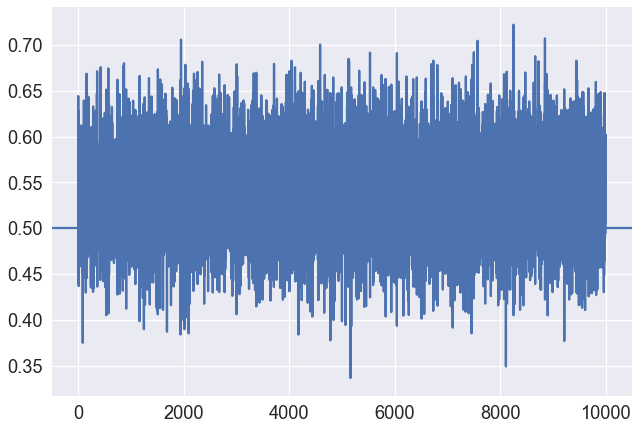

In [60]:
plt.plot(q_pheads.params.eval())
plt.axhline(y=pheads_true)

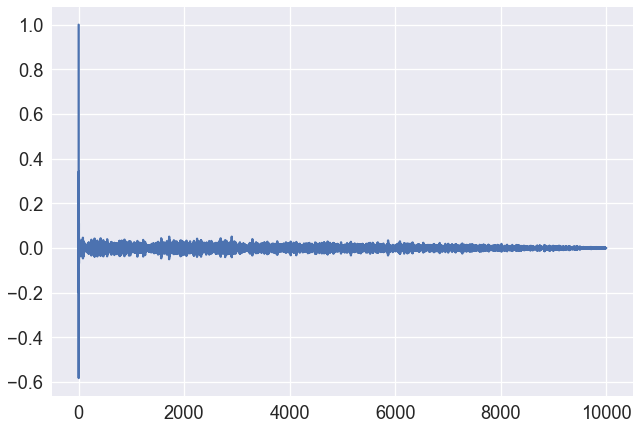

In [61]:
plt.plot(lags(q_pheads.params).eval())

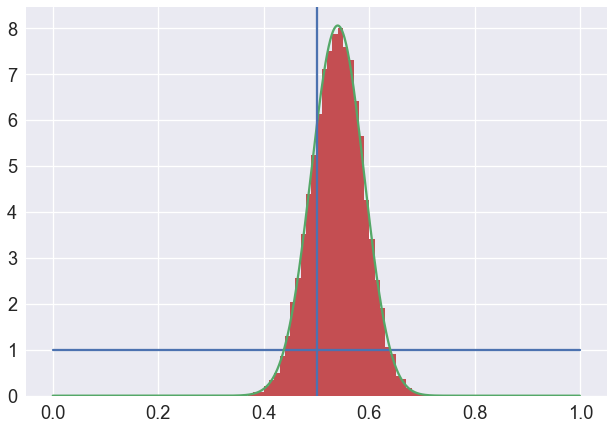

In [62]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]))
plt.plot(*sess.run([x, pheads_cond.prob(x)],
                  {c:c_train}))
plt.hist(q_pheads.params.eval(),
        bins=100, range=(0.0, 1.0),
        normed=True)
plt.axvline(x=pheads_true)

## variational inference (VI)

Good alternative to markov chain monte carlo methods. Class of algorithm that cast posterior inference as optimisation:

Approximate the model paramters, that is, the posterior p(params|data = obs):

a. build a variational backward model, q(params: lambda), over the params with some variational paramters lambda.

b. Match q(params; lambda) to p(params|obs) by optimising over lambda, 

lambda* = argmin Closeness(p(params|obs), q(params;lambda))

c. use q(params;lambda*) instead of p(params|obs)

d. criticise the variational model, revise it (-->a)

In [70]:
# BACKWARD MODEL
q_pheads_concentration1 = tf.nn.softplus(tf.Variable(51+ tf.random_normal([])))
q_pheads_concentration0 = tf.nn.softplus(tf.Variable(51+ tf.random_normal([])))
q_pheads = Beta(concentration1=q_pheads_concentration1,
               concentration0=q_pheads_concentration0)

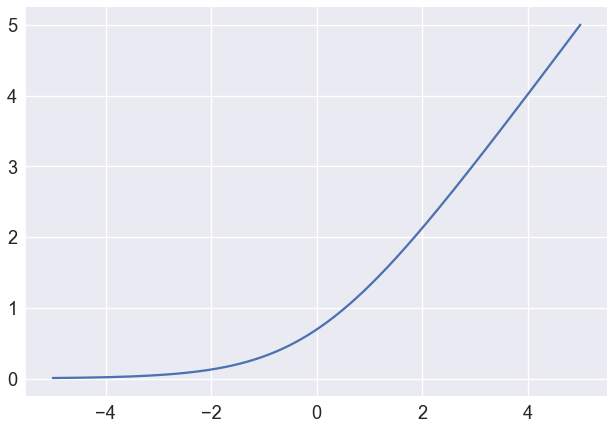

In [71]:
x = tf.range(-5.0, 5.0, 0.001)
plt.plot(*sess.run([x,tf.nn.softplus(x)]))

In [72]:
# inference
inference = ed.KLqp(latent_vars={pheads: q_pheads},
                   data={c:c_train})
inference.run(n_samples=20, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 28s | Loss: 71.154

In [73]:
sess.run({key: val for key, val in six.iteritems(q_pheads.parameters) if isinstance(val,tf.Tensor)})

{'concentration0': 46.225704, 'concentration1': 57.310051}

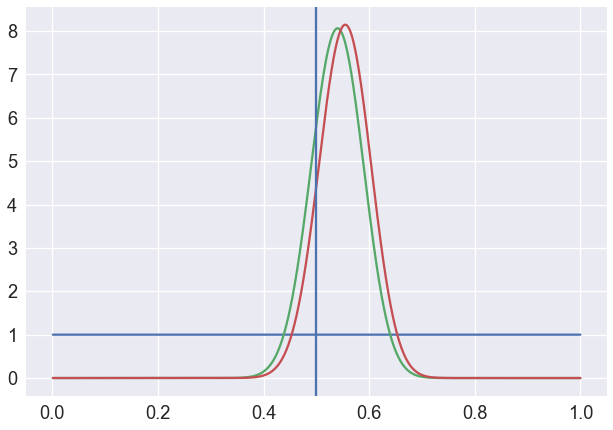

In [74]:
plt.plot(*sess.run([x,pheads.prob(x)]))
plt.plot(*sess.run([x, pheads_cond.prob(x)],
                  {c:c_train}))
plt.plot(*sess.run([x, q_pheads.prob(x)]))
plt.axvline(x=pheads_true)

In [75]:
# criticism
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev")
print(stddev)

Inferred posterior mean:
0.553529
Inferred posterior stddev
0.0486222


In [76]:
## A/B/... Testing

# Bayesian linear regression